# <center> Impact Semaine 1 : Word Embeddings systems</center> 
#### <center>  Robin Quillivic
####  <center>  23 novembre 2018 
    

# Introduction : 
Ce premier notebook a pour but d'éclaicir la notion de "representation continues des mots" (Word embeddings en anglais). En effet, cette notion est centrale pour mon projet impact qui vise à identidier les biais présents dans certaines de ces representations. Nous allons donc nous attacher dans un premier temps à comprendre (de manière non exhautive) l'état de l'art et implémenter de manière simplifier quelque uns de ces systemes de représentation.

Ce travail se base principalement sur ces sources:
- __Thèse de Sahar Ghannay (30 premières pages)__: "Etude sur les representations continues de mots appliquees à la detection automatique des erreurs dereconnaissance de la parole.
- __Serie d'article en Anglais:__ https://textminingonline.com/dive-into-nltk-part-xi-from-word2vec-to-wordnet
- __Les ressources disponibles à cette adresse__: https://textprocessing.org/getting-started-with-word2vec
- __Le papier scientifique à l'origine de Word2Vect: __ Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. Efficient Estimation of Word Representations in Vector Space. In Proceedings of Workshop at ICLR, 2013

## 1) La represention "One-hot":
Celle ci consiste à représenter les mots d'un corpus comme des vecteurs composés de 0 et de 1. Il y a un 1 pour indiquer la position du mot dans le corpus.

**Exemple simple:**

Si notre corpus **C=["Je suis un étudiant centralien en dernière année]**

Alors la représentation one-hot de notre copus est la suivante:
- "Je" $\Longrightarrow$ $(1\space 0\space  0\space  0\space  0\space   0\space  0\space  0\space )$
- "suis" $\Longrightarrow$ $(0\space 1\space  0\space  0\space  0\space   0\space  0\space  0\space )$
- etc.

On remarque que tout les vecteurs ont une  longeur de 8 car il y a 8 mots (taille de notre corpus)
Cette representation vectorielle des mot bien que très simple possède de nombreux desavantage:
- Taille des vecteurs (imaginons un corpus de la taille de wikipédia
- Absence de sens et de relation entre les mots


## 2)  L'hyposthèse de distribution [Harris, 1954],

En se basant sur l'hypothèse suivante:  **"les mots dans des contextes similaires ont des signiﬁcations semblables.**, de nombreuses nouvelle méthode sont apparues:
- **Méthode de Clustering:** On regroupe les mots en foction de leur contexte.

- **Representation distributionelle:** On se base sur des matrice de co-occurences de chaque mots.

- **Representation distribuée: Word embeddings** Les word embeddings constituent une projection des mots du vocabulaire dans un espace de faible dimension de manière à préserver les similarités sémantiques et syntaxiques. Chaque dimension représente une caractéristique latente du mot, qui peut capter des propriétés syntaxiques et sémantiques. Ces méthods plus récentes répose principalement sur les avancées du Deep Leanring et sur la comprehension des reseaux neuronaux. Ce sont actuelement les méthodes les plus performantes. 


## 3) Word2Vec
Word2Vect est l'une des boites à outils les plus performante et les plus connues en terme de representation continue des mots. Nous allons essayer de comprendre plus précisement les  algorythmes présents dans cette boite à outils.
Il y a principalement deux archutectures neuronales présentent dans Word2Vec :

- **L'architecture CBOW** : prédit le mot courant en fonction du contexte. Ainsi dans cette algorithme l'idée est de maximiser la fonction de cout suivante:
$$
\begin{equation}
S=\frac{1}{N}\sum_{i=1}^{N}log p(m_i|m_{i-n}..mm_{i-1}m_{i+1}..m_{i+n})
\end{equation}
$$
    


- **Remarques:**
    - Avec N = Nombre de mot dans le corpus et n= la taille de la fenêtre ( nombre de mot utilisé pour définir le contexte)
    - Il est important de remarquer que dans ce modèle l'ordre des mots n'a pas d'importance.
    
    

- **L'architecure Skip Ngram** : prédit les mots en contexte en fonction du mot courant. Autrement dit c'est l'inverse de la fonction precedente. Cette fois ci nous voulons maximiser cette focntion:

$$
\begin{equation}
S=\frac{1}{N}\sum_{i=1}^{N}\space \sum_{-n<j<n \ne 0} log p(m_i|m_{i+j})
\end{equation}
$$

    
    
    
![](CBOW-SKIPNGRAM.png)

- **Il existe un troisième modèle Word2Vec-deps**: qui prend en compte la nature des relations entre les mots. Aisni, le corpus d'entrainement est labélisé avec  les relations syntaxiques entre les mots. Nous detaillrons ce modèle plus tard si nous l'utilions


## 4) une implementation simple
Dans cette partie nous nous proposons d'impleter simplement chacune des deux methodes.

##### Corpus et importation

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

C:\Users\Robin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [57]:

corpus_en = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

corpus_fr = ['le roi est un homme fort',
            'la reine est une personne pleine de sagesse'
            'un garçon est un jeune homme'
            'une fille est une jeune femme'
            'homme est fort'
            'la femme est jolie'
            'le prince est un garçon qui deviendra roi'
            'la princesse est une jeune fille qui deviendra renne']

##### Focntion preliminaire

In [63]:
# Fonction qui élimines les mots inutiles ou bien trop frequent ou bien avec peu de signification
def remove_stop_words(corpus,langue='en'):
    if langue == 'en':
        stop_words = ['is', 'a', 'will', 'be']
    else :
        stop_words = ['le', 'la', 'un', 'une','est','qui','de']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

# Focntion qui créer un vecteur avec tout les mots du corpus

def create_words(corpus):
    words = []
    for text in corpus:
        for word in text.split(' '):
            words.append(word)

    words = set(words)
    return(words)

def neighbors(window_size,corpus):
    word2int = {}
    words = create_words(corpus)
    # On associe un nombre à chaque mots
    for i,word in enumerate(words):
        word2int[word] = i
        
    # On découpe notre corpus par phrase
    sentences = []
    for sentence in corpus:
        sentences.append(sentence.split())
        
    #Pour un mot donné nous créons sa liste de voisin
    data = []
    for sentence in sentences:
        for id, word in enumerate(sentence):
            for neighbor in sentence[max(id - window_size, 0) : min(id + window_size, len(sentence)) + 1] : 
                if neighbor != word:
                    data.append([word, neighbor])
    
    df = pd.DataFrame(data, columns = ['entree', 'voisin'])
    return(word2int,df)

In [6]:
clean_corpus = remove_stop_words(corpus_en)
word2int, df = neighbors(2,clean_corpus)


In [7]:
df.head()

,entree,voisin
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king


In [8]:
word2int

{'wise': 0,
 'queen': 1,
 'strong': 2,
 'young': 3,
 'boy': 4,
 'prince': 5,
 'woman': 6,
 'girl': 7,
 'princess': 8,
 'pretty': 9,
 'king': 10,
 'man': 11}

### 4-1 CBOW

### 4-2 Skip Gram

In [73]:
# FOcntion pour transformer les mot en One-hot vecteurs

def to_one_hot_encoding(data_point_index,D):
    """
    data_point_index =  La representation des mots en entiers
    D = la dimension des vecteur en one-hot
    """
    one_hot_encoding = np.zeros(D)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

 :
    # Nous créons un tablea avec tout les mots
    words = create_words(corpus)
    
    # On definit la domension pour le codage one-hot
    D=len(words)
    
    # On associe un entier a chaque mot
    # On creer la liste de tuple à partir de la taille de la fenetre
    word2int, df = neighbors(window,corpus)
    
    # On creer les vecteurs encodé en one hot pour chaque mot et chaque voisin
      
    X = [] # Vecteurs des mots en entrée
    Y = [] # vecteurs des mots voisins
    
    for x, y in zip(df['entree'], df['voisin']):
        X.append(to_one_hot_encoding(word2int[ x ],D))
        Y.append(to_one_hot_encoding(word2int[ y ],D))
    
    # on les convertie en numpy array
    
    X_train = np.asarray(X)
    Y_train = np.asarray(Y)
    
    # nous creons les place_holder
    x = tf.placeholder(tf.float32, shape=(None, D))
    y_label = tf.placeholder(tf.float32, shape=(None, D))
    
    # On chosie la dimension dans lequel sera projecté nos mots
    D_final  = 2
    
    #
    # Couche cachée : qui representera les mots finalements
    # C'est en somme un produit mtricielle
    W1 = tf.Variable(tf.random_normal([D, D_final]))
    b1 = tf.Variable(tf.random_normal([1])) #bias
    hidden_layer = tf.add(tf.matmul(x,W1), b1)
    
    # Ccouche de sortie
    W2 = tf.Variable(tf.random_normal([D_final,D]))
    b2 = tf.Variable(tf.random_normal([1]))
    
    #Focntion softmax qui nous preojecte dans [0,1]
    prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))
    
    # On definit notre founction de cout comme l'entropie croisée
    cost = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))
    
    # On définit l'operation d'entrainement qui est une descent de gradient optimisé
    # sur la fonction cout
    
    # training operation
    train_op = tf.train.GradientDescentOptimizer(0.05).minimize(cost)
    
    return(words,x,y_label,W1,b1,W2,b2,prediction,cost,train_op,X_train,Y_train)
    
    

In [76]:
def training(nbIteration,clean_corpus):
    words,x,y_label,W1,b1,W2,b2,prediction,cost,train_op,X_train,Y_train= tensor_graph(clean_corpus,2)
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init) 
    
    iteration = 1000
    for i in range(iteration):
        # Entrée :  X_train en encodage one-hot
        # Etiquettes : Les vosins de chaque mot en 
        sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
        if i % 300 == 0:
            print('Iteration '+str(i)+""" l'erreur est de :""", sess.run(cost, feed_dict={x: X_train, y_label: Y_train}))
    
    vectors_1_en = sess.run(W1 + b1)
    vectors_2_en = sess.run(W2 + b2)
    return(words,vectors_1_en)
    
    

In [77]:
clean_corpus_en = remove_stop_words(corpus_en) 
words_en, vectors_1_en = training(10000,clean_corpus_en)

print("###########################################")

clean_corpus_en = remove_stop_words(corpus_fr,langue='fr') 
words_fr,vectors_1_fr = training(10000,clean_corpus_en)

Iteration 0 l'erreur est de : 4.3602915
Iteration 300 l'erreur est de : 2.230297
Iteration 600 l'erreur est de : 2.0680375
Iteration 900 l'erreur est de : 1.9835137
###########################################
Iteration 0 l'erreur est de : 3.7725234
Iteration 300 l'erreur est de : 3.1615095
Iteration 600 l'erreur est de : 2.9786558
Iteration 900 l'erreur est de : 2.885068


In [79]:
def data_frame(vectors_1_en,words):
    df_W2V_en = pd.DataFrame(vectors_1_en, columns = ['x1', 'x2'])
    df_W2V_en['mots'] = words
    df_W2V_en = df_W2V_en[['mots', 'x1', 'x2']]
    return(df_W2V_en)

In [80]:
df_W2V_en =  data_frame(vectors_1_en,words_en)
df_W2V_fr = data_frame(vectors_1_fr,words_fr)


In [83]:

def plotGraphWord(df_W2V_en,vectors_1_en):

    plt.figure(figsize =(10,10))
    fig, ax = plt.subplots()
    
    for word, x1, x2 in zip(df_W2V_en['mots'], df_W2V_en['x1'], df_W2V_en['x2']):
        ax.annotate(word, (x1,x2 ))
        
    PADDING = 1.0
    x_axis_min = np.amin(vectors_1_en, axis=0)[0] - PADDING
    y_axis_min = np.amin(vectors_1_en, axis=0)[1] - PADDING
    x_axis_max = np.amax(vectors_1_en, axis=0)[0] + PADDING
    y_axis_max = np.amax(vectors_1_en, axis=0)[1] + PADDING
     
    plt.xlim(x_axis_min,x_axis_max)
    plt.ylim(y_axis_min,y_axis_max)
    plt.rcParams["figure.figsize"] = (10,10)
    
    plt.show()



<Figure size 720x720 with 0 Axes>

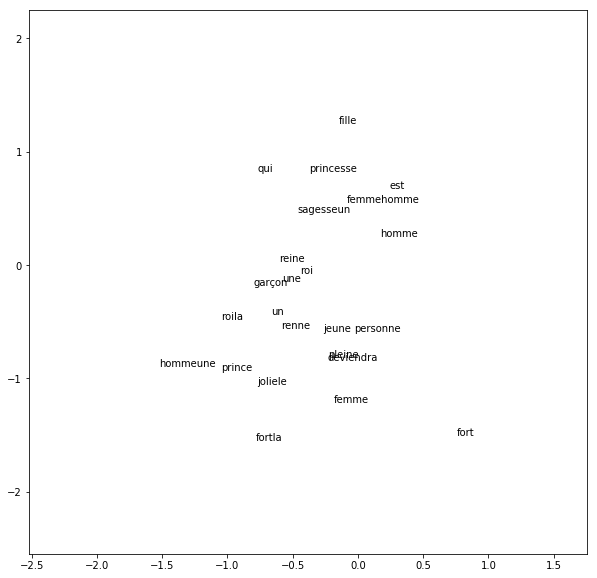

<Figure size 720x720 with 0 Axes>

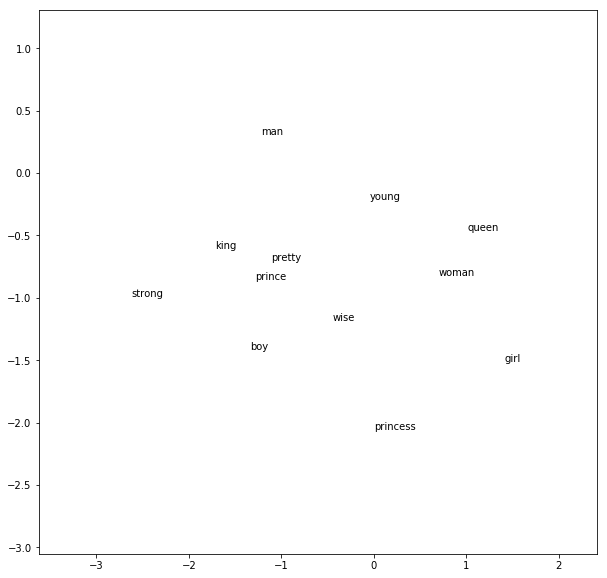

In [84]:
plotGraphWord(df_W2V_fr,vectors_1_fr)
plotGraphWord(df_W2V_en,vectors_1_en)